In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [15]:
# sync the GW folder from m100 to the ismhpc
dry_run = True
rsync_str = "rsync -rDzv --exclude={'*_fragment*','*_fragments_*','*wfc*','*.dat','.ipynb_checkpoints'} "
if dry_run: rsync_str += '-n '
ssh_str = '-e ssh m100:/m100/home/userexternal/mdaless1/work/Xenes/Stanene/GW_analysis '
dest_path = 'GW_analysis'
dest_path = os.path.abspath(dest_path)
dest_path = "'%s'"%dest_path
command = rsync_str+ssh_str+dest_path
print(command)

rsync -rDzv --exclude={'*_fragments*','*_fragments_*','*wfc*','*.dat','.ipynb_checkpoints'} -n -e ssh m100:/m100/home/userexternal/mdaless1/work/Xenes/Stanene/GW_analysis '/m100_work/IscrC_PrExIn/Stanene/GW_analysis'


In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
#code.global_options()

In [37]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 2
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='slownodes',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 2,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'slownodes',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [ ]:
# RunRules for m100
nodes = 8 # 16
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PrExIn',
                memory='240GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr)
code.global_options()

# GW convergence analysis for Stanene monolayer

We perform a convergence study for the GW runlevel

## HF Analysis

At this stage we do not repeat the convergence tests on the rim and Coulomb cutoff and we directly set
the values of the converged parameters as

* RandGVec = 200
* RandQPpts = 5000000

### HF convergence analysis for the cutoff in the exchange term

We study the convergence of the HF calculations in terms of the cutoff in the exchange term.

This analysis is performed with a 18x18x1 k-points sampling using the converged results for RIM and Coulomb cutoff.

__Note that we apply the cutoff on the EXXRLvcs variable while the VXCRLvcs is left to its DFT value__

In [4]:
input_dir = 'DFT_analysis-ONCV/kpoints_18-nbnds_30.save'
run_dir = 'GW_analysis-ONCV/kpoints_18-nbnds_30'

Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)

SAVE folder GW_analysis-ONCV/kpoints_18-nbnds_30/SAVE already present. No operations performed.


We the define the input variables commmon to all the runs

In [5]:
start_band,stop_band = 28,29 # bands range for the computation of the HF corrections
Gamma_index, K_index = 1, 37
RandGvec = 200
Randqpts = 5e6

EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -r -x -V all',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_bandRange(start_band,stop_band)
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec)
inp

{'args': 'yambo -r -x -V all',
 'folder': 'GW_analysis-ONCV/kpoints_18-nbnds_30',
 'filename': 'yambo.in',
 'arguments': ['rim_cut', 'HF_and_locXC'],
 'variables': {'StdoHash': [40.0, ''],
  'Nelectro': [28.0, ''],
  'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'OccTresh': [1e-05, ''],
  'NLogCPUs': [0.0, ''],
  'MEM_tresh': [51200.0, 'Kb'],
  'FFTGvecs': [23133.0, 'RL'],
  'SE_Threads': [0.0, ''],
  'RandQpts': [5000000.0, ''],
  'RandGvec': [200, 'RL'],
  'IDEm1Ref': [0.0, ''],
  'CUTRadius': [0.0, ''],
  'CUTCylLen': [0.0, ''],
  'CUTwsGvec': [0.7, ''],
  'EXXRLvcs': [159161.0, 'RL'],
  'VXCRLvcs': [159161.0, 'RL'],
  'DBsIOoff': 'none',
  'DBsFRAGpm': 'none',
  'PAR_def_mode': 'balanced',
  'CUTGeo': 'slab z',
  'Em1Anys': [[0.0, 0.0, 0.0], ''],
  'CUTBox': [[0.0, 0.0, 0.0], ''],
  'QPkrange': [[1, 37, 28, 29], ''],
  'QPerange': [[1, 37, 0.0, '-1.000000'], '']}}

We perform a convergence run on the EXXRLvcs parameter

In [6]:
study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

EXXRLvcs = [10.,20.,30.,40.,50.,60.,70.,80.,90.] # Ha

# append runs for the Gamma point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-G-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(Gamma_index,Gamma_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

# append runs for the K point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-K-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(K_index,K_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 2 parallel tasks


In [7]:
#study.runs[0]

In [9]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17]] 

Run the task [0, 1] 
Skip the run of hf-G-exxrlvcs_10.0Skip the run of
 hf-G-exxrlvcs_20.0
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of hf-G-exxrlvcs_30.0Skip the run of
 hf-G-exxrlvcs_40.0
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of hf-G-exxrlvcs_50.0Skip the run of
 hf-G-exxrlvcs_60.0
Task [4, 5] ended 
 
Run the task [6, 7] 
Skip the run of hf-G-exxrlvcs_70.0Skip the run of
 hf-G-exxrlvcs_80.0
Task [6, 7] ended 
 
Run the task [8, 9] 
Skip the run of hf-G-exxrlvcs_90.0
Skip the run of hf-K-exxrlvcs_10.0
Task [8, 9] ended 
 
Run the task [10, 11] 
Skip the run of hf-K-exxrlvcs_20.0Skip the run of
 hf-K-exxrlvcs_30.0
Task [10, 11] ended 
 
Run the task [12, 13] 
Skip the run of hf-K-exxrlvcs_40.0
Skip the run of hf-K-exxrlvcs_50.0
Task [12, 13] ended 
 
Run the task [

We plot the values of the gap (both at $\Gamma$ and at $K$) point

In [10]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
#gap_G,gap_K

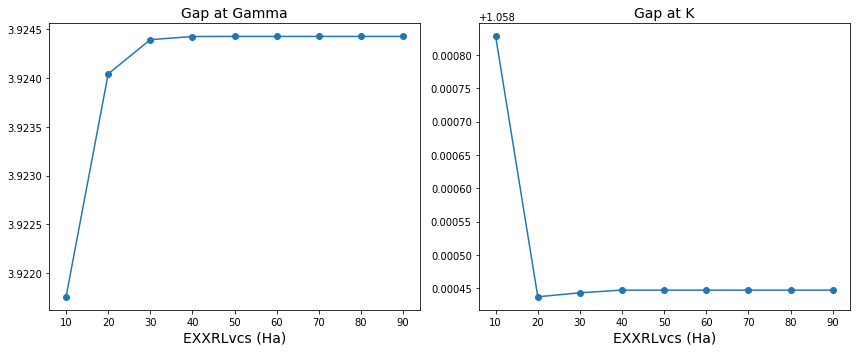

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(EXXRLvcs,gap_G)
axes[0].scatter(EXXRLvcs,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('EXXRLvcs (Ha)',size=14)
axes[1].plot(EXXRLvcs, gap_K)
axes[1].scatter(EXXRLvcs,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('EXXRLvcs (Ha)',size=14)
fig.tight_layout()

On the basis of this analysis we choose the converged value of the cutoff for exchange as

EXXRLvcs = 40 Ha

### HF Analysis in function of the k-points sampling

We test the convergence of the HF gap at $K$ and at the $\Gamma$ points in funciont of the dimension of the $k$-points sampling.

The converged parameters for the RIM and Coulomb cutoff and for the cutoff on the exchange derived in the previous analysis will be used.

In [30]:
RandQpts = 5000000
RandGvec = 200 

start_band,stop_band = 28,29 # bands range for the computation of the HF corrections
Gamma_index = {18:1,30:1,42:1,60:1,72:1}
K_index = {18:37,30:91,42:169,60:331,72:469}

EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

In [31]:
kpoints = [18,30,42,60,72]

In [32]:
study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    input_dir = 'DFT_analysis-ONCV/kpoints_%s-nbnds_30.save'%k
    run_dir = 'GW_analysis-ONCV/kpoints_%s-nbnds_30'%k
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)
    
    inp = I.YamboInput(args='yambo -r -x -V all',folder=run_dir)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs) #,VXCRLvcs=EXXRLvcs)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.1.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
    
    # append run at G
    idd = 'hf-G-kpoints_%s'%k
    inp.set_kRange(Gamma_index[k],Gamma_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff'])
    # append run at K
    idd = 'hf-K-kpoints_%s'%k
    inp.set_kRange(K_index[k],K_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff'])

Initialize a Dataset with 2 parallel tasks
SAVE folder GW_analysis-ONCV/kpoints_18-nbnds_30/SAVE already present. No operations performed.
SAVE folder GW_analysis-ONCV/kpoints_30-nbnds_30/SAVE already present. No operations performed.
SAVE folder GW_analysis-ONCV/kpoints_42-nbnds_30/SAVE already present. No operations performed.
SAVE folder GW_analysis-ONCV/kpoints_60-nbnds_30/SAVE already present. No operations performed.
SAVE folder GW_analysis-ONCV/kpoints_72-nbnds_30/SAVE already present. No operations performed.


In [33]:
#study.runs[0]

In [34]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]] 

Run the task [0, 1] 
Skip the run of hf-G-kpoints_18
Skip the run of hf-K-kpoints_18
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of hf-G-kpoints_30
Skip the run of hf-K-kpoints_30
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of hf-G-kpoints_42
Skip the run of hf-K-kpoints_42
Task [4, 5] ended 
 
Run the task [6, 7] 
Skip the run of hf-G-kpoints_60Skip the run of
 hf-K-kpoints_60
Task [6, 7] ended 
 
Run the task [8, 9] 
Skip the run of hf-G-kpoints_72
delete job_out script: GW_analysis-ONCV/kpoints_72-nbnds_30/job_hf-K-kpoints_72.out
delete folder: GW_analysis-ONCV/kpoints_72-nbnds_30/hf-K-kpoints_72
run command: mpirun -np 16 yambo -F hf-K-kpoints_72.in -J "hf-K-kpoints_72,ndb_rim_cutoff" -C hf-K-kpoints_72
slurm submit:  cd GW_analysis-ONCV/kpoints_72-nbnds_30 ; sbatch job_hf-K-kpoints_72.sh
computation hf-K-kpoints_72 is running...
computatio

In [35]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G, gap_K = [],[]
for ind,k in enumerate(kpoints):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
gap_G, gap_K

([3.924426, 3.869248, 3.86092, 3.860386, 3.860988],
 [1.058447, 0.906915, 0.858323, 0.8339890000000001, 0.828608])

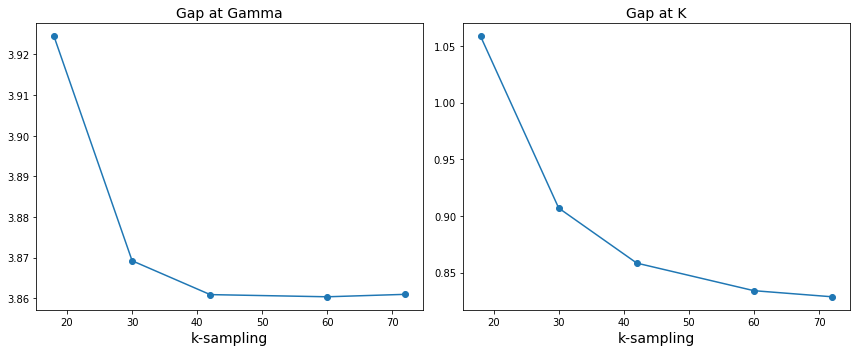

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints,gap_G)
axes[0].scatter(kpoints,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('k-sampling',size=14)
axes[1].plot(kpoints, gap_K)
axes[1].scatter(kpoints,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('k-sampling',size=14)
fig.tight_layout()

With the 60x60x1 sampling the HF gap both at $\Gamma$ and at $K$ is converged at
the level of 5 meV.

## Plasmon pole analysis

We study the convergence of the gap at $\Gamma$ and at $K$ using the plasmon pole run level. 

The aim of this analysis is to find a converged expression for the screening (that will be used also in the BSE calculations)
and to test the RIM_W.

### Convergence analysis of the screening

We use the 18x18x1 k-points sampling and perform a convergence analysis in the BndsRnXp and GbndRnge parameters
needed to compute the screening function.

We perform this analysis using the RIM_W with RandGvecW=10.

In [11]:
input_dir = 'DFT_analysis-ONCV/kpoints_18-nbnds_500.save'
run_dir = 'GW_analysis-ONCV/kpoints_18-nbnds_500'
Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)

SAVE folder GW_analysis-ONCV/kpoints_18-nbnds_500/SAVE already present. No operations performed.


We the define the input variables common to all the runs

In [38]:
ntasks_c = 32 #16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 28,29
Gamma_index, K_index = 1, 37
RandGvec = 200
RandGvecW = 10
Randqpts = 5e6

EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.activate_RIM_W()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs) 
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
#inp

32 2


First we run over NGsBlkXp

In [39]:
NGsBlkXp = [4.0,6.0,8.0,10.] # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,300] # Bands in the response function
GbndRnge = [1,300]  # Bands in the Sigma_c

inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)

study = D.Dataset(num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for ngsblkxp in NGsBlkXp:
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=ngsblkxp)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_G','ndb_dipoles-nbnds_500',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])],reformat=False)
    # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K','ndb_dipoles-nbnds_500',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])],reformat=False)

Initialize a Dataset with 4 parallel tasks


In [41]:
#study.runs[6]

In [ ]:
results = study.run(selection=[6])

Run the selection [6] with the parallel task_groups [[6]] 

Run the task [6] 
delete job_out script: GW_analysis-ONCV/kpoints_18-nbnds_500/job_pp-G-ngsblkxp_10.0-bndsrnxp_300-gbndrnge_300.out
delete folder: GW_analysis-ONCV/kpoints_18-nbnds_500/pp-G-ngsblkxp_10.0-bndsrnxp_300-gbndrnge_300
run command: mpirun -np 64 yambo -F pp-G-ngsblkxp_10.0-bndsrnxp_300-gbndrnge_300.in -J "pp-G-ngsblkxp_10.0-bndsrnxp_300-gbndrnge_300,ndb_rim_cutoff,ndb_hf_G,ndb_dipoles-nbnds_500,ndb_em1d-ngsblkxp_10.0-bndsrnxp_300" -C pp-G-ngsblkxp_10.0-bndsrnxp_300-gbndrnge_300
slurm submit:  cd GW_analysis-ONCV/kpoints_18-nbnds_500 ; sbatch job_pp-G-ngsblkxp_10.0-bndsrnxp_300-gbndrnge_300.sh
computation pp-G-ngsblkxp_10.0-bndsrnxp_300-gbndrnge_300 is running...


In [35]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([0.799132, 0.800351, 0.797613],
 [0.176307, 0.17599200000000004, 0.17595700000000003])

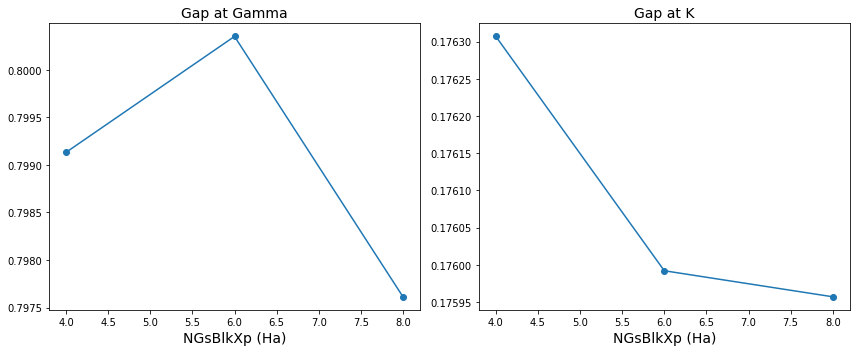

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(NGsBlkXp,gap_G)
axes[0].scatter(NGsBlkXp,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].plot(NGsBlkXp, gap_K)
axes[1].scatter(NGsBlkXp,gap_K)
axes[1].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We choose the value NGsBlkXp = 8 Ha that ensures convergence at the level of 1 meV (or better) for
both the $\Gamma$ and the K points.

In [46]:
NGsBlkXp = 8.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [[1,300],[1,400],[1,500]] # Bands in the response function
GbndRnge = [1,300]  # Bands in the Sigma_c

inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(GbndRnge=GbndRnge)

study = D.Dataset(num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for bndsrnxp in BndsRnXp:
    inp.set_array_variables(BndsRnXp=bndsrnxp)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bndsrnxp[1],GbndRnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_G','ndb_dipoles-nbnds_500',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,bndsrnxp[1])],reformat=False) 
    # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bndsrnxp[1],GbndRnge[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K','ndb_dipoles-nbnds_500',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,bndsrnxp[1])],reformat=False) 

Initialize a Dataset with 4 parallel tasks


In [47]:
#study.runs[8]

In [48]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9]] 

Run the task [0, 1, 2, 3] 
Skip the run of Skip the run ofpp-G-ngsblkxp_8.0-bndsrnxp_100-gbndrnge_100 
pp-K-ngsblkxp_8.0-bndsrnxp_100-gbndrnge_100
Skip the run of pp-K-ngsblkxp_8.0-bndsrnxp_200-gbndrnge_100
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_200-gbndrnge_100
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of pp-K-ngsblkxp_8.0-bndsrnxp_300-gbndrnge_100
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_300-gbndrnge_100
Skip the run of pp-K-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_100
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_100
Task [4, 5, 6, 7] ended 
 
Run the task [8, 9] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_100
Skip the run of pp-K-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_100
Task [8, 9] ended 
 


In [49]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([0.532116, 0.512975, 0.502509, 0.494882, 0.490477],
 [0.137242, 0.140172, 0.140457, 0.140402, 0.140088])

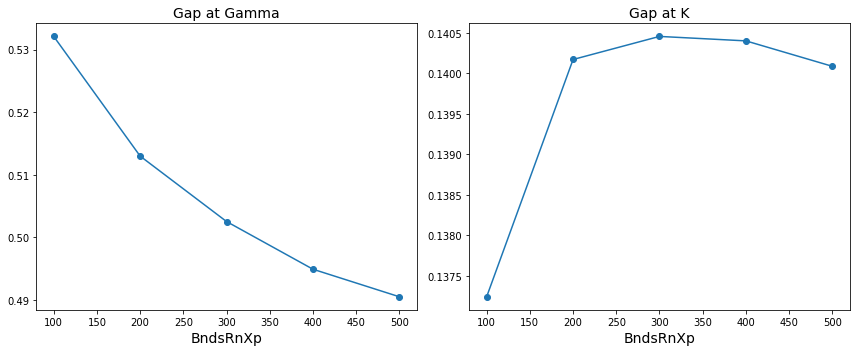

In [50]:
x_vals = [x[1] for x in BndsRnXp]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(x_vals,gap_G)
axes[0].scatter(x_vals,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('BndsRnXp',size=14)
axes[1].plot(x_vals, gap_K)
axes[1].scatter(x_vals,gap_K)
axes[1].set_xlabel('BndsRnXp',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We observe that 500 bands are sufficient to provide convergence at K whereas the convergence of the gap at $\Gamma$
requires more bands. 

Moreover, as pointed out in the literature, an ulterior convergence test on the NGsBlkXp parameter should be performed
since this parameter is connected to the BndsRnXp so the convergence test previously performed should not be 
completely reliable. We will perform this analysis afterwards.

Lastly we perform the convergence check on the number of bands used in the G expansion.

We use the Bruneval-Gonze (BG) terminator to improve the convergence on the GbndRnge parameter.

In [51]:
NGsBlkXp = 8.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,500] # Bands in the response function
GbndRnge = [[1,100],[1,200],[1,300],[1,400],[1,500]]  # Bands in the Sigma_c

inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp)

study = D.Dataset(num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for gbndrnge in GbndRnge:
    inp.set_array_variables(GbndRnge=gbndrnge)
    # append run at G
    inp.set_scalar_variables(GTermKind='BG')
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-BG_term'%(NGsBlkXp,BndsRnXp[1],gbndrnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_G','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)
    inp.set_scalar_variables(GTermKind='none')
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,BndsRnXp[1],gbndrnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_G','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)
    
    # append run at K
    inp.set_scalar_variables(GTermKind='BG')
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-BG_term'%(NGsBlkXp,BndsRnXp[1],gbndrnge[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)
    inp.set_scalar_variables(GTermKind='none')
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,BndsRnXp[1],gbndrnge[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)

Initialize a Dataset with 4 parallel tasks


In [52]:
#study.ids
#study.runs[1]

In [53]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15], [16, 17, 18, 19]] 

Run the task [0, 1, 2, 3] 
Skip the run ofSkip the run of  pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_100pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_100-BG_term

Skip the run of pp-K-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_100
Skip the run of pp-K-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_100-BG_term
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_200-BG_term
Skip the run of Skip the run ofpp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_200 
pp-K-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_200-BG_term
Skip the run of pp-K-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_200
Task [4, 5, 6, 7] ended 
 
Run the task [8, 9, 10, 11] 
Skip the run ofSkip the run of  pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_300-BG_termpp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_300

Skip the run of pp-K-

In [54]:
results_G_BG = [results[r] for r in [0,4,8,12,16]]
results_G = [results[r] for r in [1,5,9,13,17]]
results_K_BG = [results[r] for r in [2,6,10,14,18]]
results_K = [results[r] for r in [3,7,11,15,19]]

In [55]:
gap_G, gap_G_BG = [],[]
for ind in range(len(GbndRnge)):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False))
    gap_G_BG.append(results_G_BG[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False))

gap_K, gap_K_BG = [],[]
for ind in range(len(GbndRnge)):
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index,band_full=start_band,verbose=False))
    gap_K_BG.append(results_K_BG[ind].data.get_gap(k_full=K_index,band_full=start_band,verbose=False))

In [56]:
gap_G,gap_G_BG,GbndRnge

([0.490477, 0.558478, 0.573739, 0.57903, 0.57634],
 [0.5950799999999999,
  0.6145499999999999,
  0.615063,
  0.6141519999999999,
  0.611059],
 [[1, 100], [1, 200], [1, 300], [1, 400], [1, 500]])

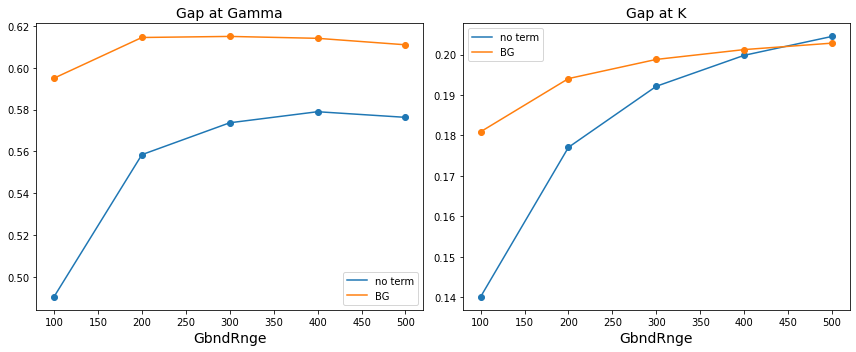

In [57]:
xvals = [gbndrnge[1] for gbndrnge in GbndRnge]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(xvals,gap_G,label='no term')
axes[0].scatter(xvals,gap_G)
axes[0].plot(xvals, gap_G_BG,label='BG')
axes[0].scatter(xvals,gap_G_BG)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('GbndRnge',size=14)
axes[1].plot(xvals, gap_K,label='no term')
axes[1].scatter(xvals,gap_K)
axes[1].plot(xvals, gap_K_BG,label='BG')
axes[1].scatter(xvals,gap_K_BG)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('GbndRnge',size=14)
axes[0].legend()
axes[1].legend()
fig.tight_layout()

We observe that: 
* the usage of the BG terminator leads to a (apparently) different asymptotic value at $\Gamma$
* at K the values are the same but there no advantage in using the terminator with 500 bands
* the computational cost of the single computation is higher with the terminato

So we do not use the terminator in the subsequent computations.

On the basis of this analysis we conclude that : 
* NGsBlkXp = 8 Ha, BndsRnXp = GbndRnge = 500 (without a BG terminator on the GbndRnge parameter) seems to ensure
  convergence within 5 meV. However further test could be needed to ensure that the convergence is reliable.
  In particular a test on the NGsBlkXp with BndsRnXp = 500 should be performed

### Analysis of RIM_W convergence

We perform a convergence analysis on the number of G vectors in the RIM_W procedure

In [35]:
tasks_c = 16 #16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 28,29
Gamma_index, K_index = 1, 37
RandGvec = 200
Randqpts = 5e6

EXXRLvcs = 60. # Ha
EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.activate_RIM_W()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec)
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp)
#inp.set_scalar_variables(GTermKind='BG') # actual runs have been performed with BG but it should be not relevant for the RIM_W convergence
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.1.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
#inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
#inp

32 1


In [36]:
RandGvecW =[2,10,20]

study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for randgvecw in RandGvecW:
    inp.set_array_variables(units='RL',RandGvecW=randgvecw)
    # append run at G
    idd = 'pp-G-RIM_W-randgvecw_%s'%randgvecw
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_G','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)
    # append run at K
    idd = 'pp-K-RIM_W-randgvecw_%s'%randgvecw
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)

Initialize a Dataset with 2 parallel tasks


In [40]:
#study.runs[2]

In [41]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0, 1], [2, 3], [4, 5]] 

Run the task [0, 1] 
run command: mpirun -np 32 yambo -F pp-G-RIM_W-randgvecw_2.in -J "pp-G-RIM_W-randgvecw_2,ndb_rim_cutoff,ndb_hf_G,ndb_em1d-ngsblkxp_8.0-bndsrnxp_500" -C pp-G-RIM_W-randgvecw_2
slurm submit:  cd GW_analysis/kpoints_18-nbnds_500 ; sbatch job_pp-G-RIM_W-randgvecw_2.sh
run command: mpirun -np 32 yambo -F pp-K-RIM_W-randgvecw_2.in -J "pp-K-RIM_W-randgvecw_2,ndb_rim_cutoff,ndb_hf_K,ndb_em1d-ngsblkxp_8.0-bndsrnxp_500" -C pp-K-RIM_W-randgvecw_2
slurm submit:  cd GW_analysis/kpoints_18-nbnds_500 ; sbatch job_pp-K-RIM_W-randgvecw_2.sh
computation pp-G-RIM_W-randgvecw_2 is running...computation pp-K-RIM_W-randgvecw_2 is running...

computation pp-K-RIM_W-randgvecw_2 ended
Run performed in 39m-37s
computation pp-G-RIM_W-randgvecw_2 ended
Run performed in 39m-41s
Task [0, 1] ended 
 
Run the task [2, 3] 
run command: mpirun -np 32 yambo -F pp-G-RIM_W-randgvecw_10.in -J "pp-G-RIM_W-randg

In [42]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([0.611059, 0.610923, 0.6106999999999999],
 [0.20284000000000002, 0.20250400000000002, 0.20238899999999999])

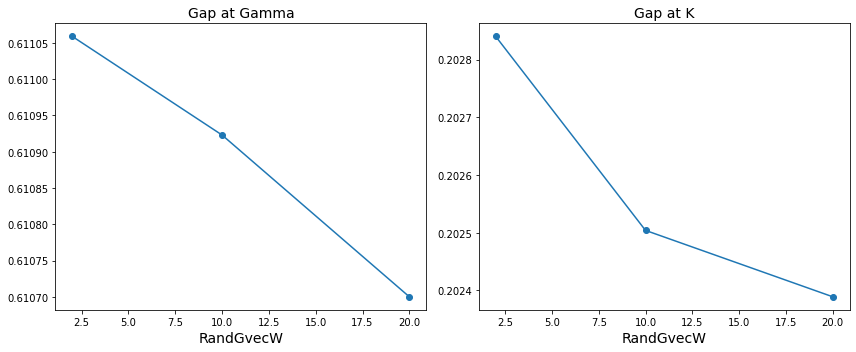

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(RandGvecW,gap_G)
axes[0].scatter(RandGvecW,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('RandGvecW',size=14)
axes[1].plot(RandGvecW, gap_K)
axes[1].scatter(RandGvecW,gap_K)
axes[1].set_xlabel('RandGvecW',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

On the basis of this analysis we see that convergence is achieved even for the first case and we set RandGvecW = 10
as a safety choice for the converged value for this parameter.

### Further convergence test on the NGsBlkXp to check the cross-correlation with the number of bands

Lastly we perform a further convergence check on the NGsBlkXp using 500 bands to see check the convergence
of the choice NGsBlkXp = 8 Ha

In [5]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 28,29
Gamma_index, K_index = 1, 37
RandGvec = 200
RandGvecW = 10
Randqpts = 5e6

EXXRLvcs = 60. # Ha
EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.activate_RIM_W()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='4.1.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
#inp

16 2


In [10]:
NGsBlkXp = [8.0,10.] # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,500] # Bands in the response function
GbndRnge = [1,500]  # Bands in the Sigma_c

inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for ngsblkxp in NGsBlkXp:
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=ngsblkxp)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_G','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])],reformat=False)
    # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [11]:
#study.runs[3]

In [13]:
results = study.run()

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0], [1], [2], [3]] 

Run the task [0] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500
Task [0] ended 
 
Run the task [1] 
Skip the run of pp-K-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500
Task [1] ended 
 
Run the task [2] 
Skip the run of pp-G-ngsblkxp_10.0-bndsrnxp_500-gbndrnge_500
Task [2] ended 
 
Run the task [3] 
Skip the run of pp-K-ngsblkxp_10.0-bndsrnxp_500-gbndrnge_500
Task [3] ended 
 


In [14]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([0.57634, 0.575865], [0.20450399999999996, 0.20404100000000003])

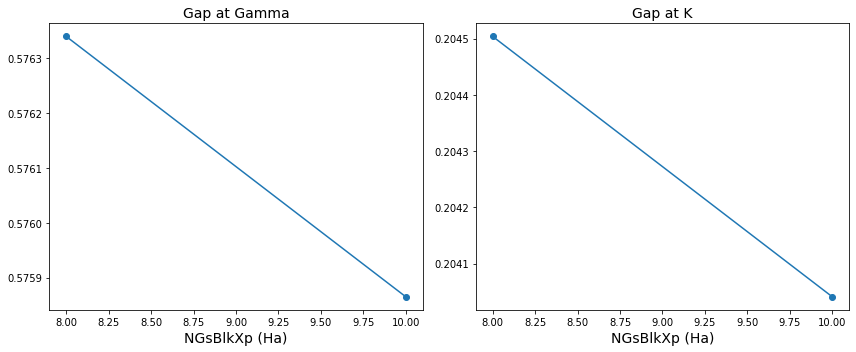

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(NGsBlkXp,gap_G)
axes[0].scatter(NGsBlkXp,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].plot(NGsBlkXp, gap_K)
axes[1].scatter(NGsBlkXp,gap_K)
axes[1].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We observe that, increasing the NGsBlkXp with 500 bands, the gaps remain stable at the level of the meV.

### PP Analysis in function of the k-points sampling

We test the convergence of the PP gap at $K$ and at the $\Gamma$ points in function of the dimension of the $k$-points sampling.

Note that this analysis is performed without the BG terminator, since we have understood that usage of this terminator is not useful and may lead to erroneous results at $\Gamma$. 

In [4]:
kpoints = [18,30,42,60,72]

In [5]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 28,29
Gamma_index = {18:1,30:1,42:1,60:1,72:1}
K_index = {18:37,30:91,42:169,60:331,72:469}
RandGvec = 200
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 60. # Ha
EXXRLVcs_units = 'Ha'
NGsBlkXp = 8.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,500]# Bands in the response function
GbndRnge = [1,500] # Bands in the Sigma_c

study = D.Dataset(num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    input_dir = 'DFT_analysis/kpoints_%s-nbnds_500.save'%k
    run_dir = 'GW_analysis/kpoints_%s-nbnds_500'%k
    #Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)
    Tools.build_r_setup(yambo_dir=run_dir)
    #Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir,
    #        p2y_command='mpirun -np 1 p2y',yambo_command='mpirun -np 1 yambo')

    inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
    inp.set_extendOut()
    inp.activate_RIM_W()
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_bandRange(start_band,stop_band)
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
    inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
    #inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.1.16') # for 8 nodes on m100
    inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
    inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
    
    # append run at G
    inp.set_kRange(Gamma_index[k],Gamma_index[k])
    idd = 'pp-G-kpoints_%s'%k
    jobname = [idd,'ndb_rim_cutoff','ndb_hf_G',
               'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),'ndb_dipoles-nbnds_500']
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=jobname,reformat=False)
    # append run at K
    inp.set_kRange(K_index[k],K_index[k])
    idd = 'pp-K-kpoints_%s'%k
    jobname = [idd,'ndb_rim_cutoff','ndb_hf_K',
               'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),'ndb_dipoles-nbnds_500']
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=jobname,reformat=False)

16 2
Initialize a Dataset with 1 parallel tasks
Build the r_setup in the yambo_dir path GW_analysis/kpoints_72-nbnds_500


In [6]:
study.ids

['pp-G-kpoints_18',
 'pp-K-kpoints_18',
 'pp-G-kpoints_30',
 'pp-K-kpoints_30',
 'pp-G-kpoints_42',
 'pp-K-kpoints_42',
 'pp-G-kpoints_60',
 'pp-K-kpoints_60',
 'pp-G-kpoints_72',
 'pp-K-kpoints_72']

In [7]:
#study.runs[1]

In [8]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]] 

Run the task [0] 
Skip the run of pp-G-kpoints_18
Task [0] ended 
 
Run the task [1] 
Skip the run of pp-K-kpoints_18
Task [1] ended 
 
Run the task [2] 
Skip the run of pp-G-kpoints_30
Task [2] ended 
 
Run the task [3] 
Skip the run of pp-K-kpoints_30
Task [3] ended 
 
Run the task [4] 
Skip the run of pp-G-kpoints_42
Task [4] ended 
 
Run the task [5] 
Skip the run of pp-K-kpoints_42
Task [5] ended 
 
Run the task [6] 
Skip the run of pp-G-kpoints_60
Task [6] ended 
 
Run the task [7] 
Skip the run of pp-K-kpoints_60
Task [7] ended 
 
Run the task [8] 
Skip the run of pp-G-kpoints_72
Task [8] ended 
 
Run the task [9] 
Skip the run of pp-K-kpoints_72
Task [9] ended 
 


In [9]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G,gap_K = [],[]
for ind,k in enumerate(kpoints):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
gap_G,gap_K

([0.5761360000000001,
  0.60735,
  0.6211709999999999,
  0.6250579999999999,
  0.630469],
 [0.20417100000000005,
  0.183747,
  0.17919300000000005,
  0.173921,
  0.17568399999999995])

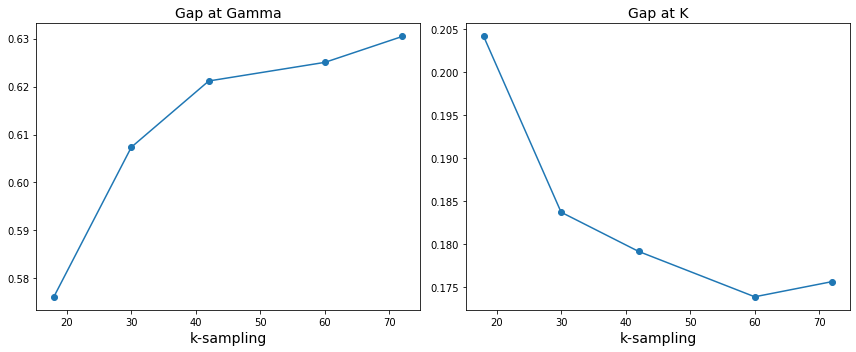

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints,gap_G)
axes[0].scatter(kpoints,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('k-sampling',size=14)
axes[1].plot(kpoints, gap_K)
axes[1].scatter(kpoints,gap_K)
axes[1].set_xlabel('k-sampling',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We conclude that the value
$$
E_{gap} = 176 meV
$$
is the best estimate of the gap of the Stanene at K

## Quasi-particle band structure

We use the convergence test performed above to computed the GW correction in the whole BZ. 
In this way we can compute the quasi-particle correction of the band structure.

At this level of the analysis we perform these computations for the 30x30x1 $k$-points samplings.

In [8]:
kpoints = 30
run_dir = 'GW_analysis/kpoints_%s-nbnds_500'%kpoints

In [9]:
ntasks_c = 32
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 25,32
RandGvec = 200
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 60. # Ha
EXXRLVcs_units = 'Ha'
NGsBlkXp = 8.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,500]# Bands in the response function
GbndRnge = [1,500] # Bands in the Sigma_c

inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.activate_RIM_W()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_bandRange(start_band,stop_band)
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
inp

32 2


{'args': 'mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',
 'folder': 'GW_analysis/kpoints_30-nbnds_500',
 'filename': 'yambo.in',
 'arguments': ['rim_cut',
  'em1d',
  'gw0',
  'HF_and_locXC',
  'ppa',
  'ExtendOut',
  'RIM_W'],
 'variables': {'StdoHash': [40.0, ''],
  'Nelectro': [28.0, ''],
  'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'OccTresh': [1e-05, ''],
  'NLogCPUs': [0.0, ''],
  'MEM_tresh': [51200.0, 'Kb'],
  'FFTGvecs': [23661.0, 'RL'],
  'X_and_IO_nCPU_LinAlg_INV': [-1.0, ''],
  'X_Threads': [0.0, ''],
  'DIP_Threads': [0.0, ''],
  'SE_Threads': [0.0, ''],
  'RandQpts': [5000000.0, ''],
  'RandGvec': [200, 'RL'],
  'IDEm1Ref': [0.0, ''],
  'CUTRadius': [0.0, ''],
  'CUTCylLen': [0.0, ''],
  'CUTwsGvec': [0.7, ''],
  'EXXRLvcs': [60.0, 'Ha'],
  'VXCRLvcs': [60.0, 'Ha'],
  'XfnQP_INTERP_NN': [1.0, ''],
  'XfnQP_INTERP_shells': [20.0, ''],
  'XfnQP_Wv_E': [0.0, 'eV'],
  'XfnQP_Wv_dos': [0.0, 'eV'],
  'XfnQP_Wc_E': [0.0, 'eV'],
  'XfnQP_Wc_dos': [0.0, 'eV']

In [ ]:
idd = 'pp-allBZ-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,BndsRnXp[1],GbndRnge[1])
jobname = [idd,'ndb_rim_cutoff','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),
           'ndb_dipoles-nbnds_500','ndb_hf_allBZ']
results = code.run(input=inp,run_dir=run_dir,name=idd,jobname=jobname,reformat=False)

run command: mpirun -np 64 yambo -F pp-allBZ-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500.in -J "pp-allBZ-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500,ndb_rim_cutoff,ndb_em1d-ngsblkxp_8.0-bndsrnxp_500,ndb_dipoles-nbnds_500,ndb_hf_allBZ" -C pp-allBZ-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500
slurm submit:  cd GW_analysis/kpoints_30-nbnds_500 ; sbatch job_pp-allBZ-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500.sh
computation pp-allBZ-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500 is running...


### Ypp analysis

We use the previous results to compute the GW correction of the band structure along a high symmetry path.

In [88]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #fastnodes
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
ypp_code = C.YamboCalculator(rr,executable='ypp',activate_BeeOND=True) 
#ypp_code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [89]:
ndbQP = 'pp-allBZ-ngsblkxp_6.0-bndsrnxp_250-gbndrnge_250/ndb.QP'

In [90]:
# with BANDS_kpts

band_range = [start_band,stop_band]
bands_step = 50

# in crystal coordinates
G = [0.,0.,0.]
Kp = [1./3.,1./3.,0.]
Mp = [0.,0.5,0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path
path = [G,Mp,Kp,G]

study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)

inp = I.YamboInput(args='mpirun -np 1 ypp -s b -V qp',folder=run_dir,filename='ypp.in')
inp.set_array_variables(BANDS_bands=band_range,BANDS_steps=bands_step,BANDS_kpts=path)
inp.set_array_variables(GfnQP_E=GfnQP_E[k])
inp.set_scalar_variables(cooIn='rlu',cooOut='rlu')

idd = 'ypp_bands_dft_boltz'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [20,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [20,'']
study.append_run(id=idd,input=inp,runner=ypp_code) 

idd = 'ypp_bands_gw_boltz'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [10,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [10,'']
inp['variables']['GfnQPdb']= 'E < %s'%ndbQP
study.append_run(id=idd,input=inp,runner=ypp_code)

Initialize a Dataset with 2 parallel tasks


In [91]:
#study.runs[1]

In [92]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0, 1]] 

Run the task [0, 1] 
run command: mpirun -np 16 ypp -F ypp_bands_gw_boltz.in -J ypp_bands_gw_boltz -C ypp_bands_gw_boltz
slurm submit:  cd GW_analysis/kpoints_30-nbnds_250 ; sbatch job_ypp_bands_gw_boltz.sh
computation ypp_bands_gw_boltz is running...
run command: mpirun -np 16 ypp -F ypp_bands_dft_boltz.in -J ypp_bands_dft_boltz -C ypp_bands_dft_boltz
slurm submit:  cd GW_analysis/kpoints_30-nbnds_250 ; sbatch job_ypp_bands_dft_boltz.sh
computation ypp_bands_dft_boltz is running...
computation ypp_bands_dft_boltz ended
Run performed in 10s
computation ypp_bands_gw_boltz ended
Run performed in 11s
Task [0, 1] ended 
 


In [93]:
bands_gw = U.BandStructure.from_Ypp(results[1],high_sym,suffix='bands_interpolated')
bands_dft = U.BandStructure.from_Ypp(results[0],high_sym,suffix='bands_interpolated')

We show the GW correction for the valence and conduction bands

Text(0.5, 1.0, 'MoS$_2$ GW bands')

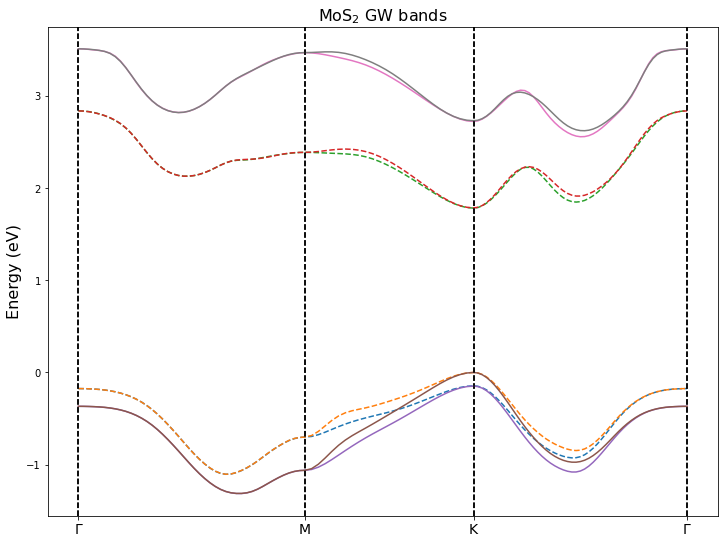

In [86]:
# Results for the 18x18x1 kpoints sampling 

fig, ax = plt.subplots(figsize=(12, 9))
bands_dft.plot(plt,selection=[2,3,4,5],linestyle='--',label='dft')
bands_gw.plot(plt,selection=[2,3,4,5],linestyle='-',label='gw')
ax.set_ylabel('Energy (eV)',size=16)
plt.title('MoS$_2$ GW bands',size=16)